Connect to database

In [1]:
import mysql.connector

# connect to remote db
cnx = mysql.connector.connect(user="emlyon1",
                              password="student1",
                              host="analyst-toolbelt.cn119w37trlg.eu-west-1.rds.amazonaws.com",
                              database="B2B")
cursor = cnx.cursor()

# execute mysql query, retrieve all tweets concerning alstom 
query = ("SELECT * FROM tweet WHERE searchterm = '@Alstom'")
cursor.execute(query)

# load result in python list
tweets = list(cursor)
print("Number of tweets:", len(tweets))

Number of tweets: 10567


get a frequency of words

In [2]:
import collections

# keep only text row
texts = list(map(lambda x: x[2], tweets))

# get a list of words
words = " ".join(texts).split()
print ("Number of words:", len(words))

# get a dictionary worted by frequency
dic = collections.Counter(words).most_common()
print ("10 most common common words and their frequencies:")
dic[:10]

Number of words: 176947
10 most common common words and their frequencies:


[('RT', 7026),
 ('@Alstom', 5518),
 ('@Alstom:', 3096),
 ('the', 2866),
 ('in', 1995),
 ('to', 1932),
 ('of', 1916),
 ('de', 1841),
 ('a', 1701),
 ('for', 1452)]

create a workcloud using wordcloud lib

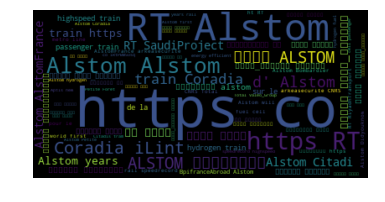

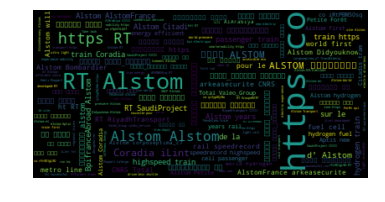

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# get one sgnle text
text = " ".join(texts)

# create a workcloud 
wordcloud = WordCloud().generate(text)


# matplotlib image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
# pillow imgae
image = wordcloud.to_image()
image.show()
